## Task 06: Unsupervised Learning (2022-04-26)

Using the 3-storey dataset from previous activities, perform the following (having features constructed with AR models and PCA):
- Apply the k-means algorithm with the reduced dimensions
    - Check the results visually by plotting side by side your clustering results and the correct labels in 3D (using only 3 dimensions of the PCA in the input space);
    - Optional: try to assign to clusters the label which contain most instances of a class, and build the confusion matrices based on this information (this will require some coding).
- Visualize your dataset with t-SNE;
- Build a one-class classification SVM for nominal and failure modes

In [42]:
# execute this for the 1st time
# !pip install -r example-requirements.txt 

# download file 
# !wget http://helon.usuarios.rdc.puc-rio.br/data/data3SS2009.mat # linux

# and place in folder data/

In [3]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

# task 03
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.model_selection import RandomizedSearchCV

# task 05
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#allow to print all variables in the notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from scipy import stats

### Opening data file and Separating parameters and labels

In [6]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)

### Creating new label y2 considering the classification as: (in case we use it as a supervised label instead of the 17 classes)

- y=(1..9) - undamaged, y2 = 0
- y=(10..17) - damaged, y2 = 1

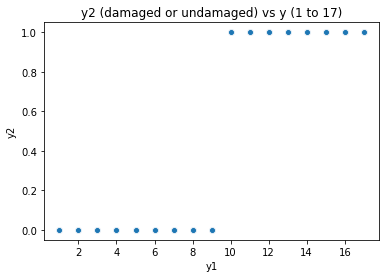

In [7]:
y2 = []
for label in y:
    if label in range(1,10):
        y2.append(0)
    else: y2.append(1)
y2 = np.array(y2)
ax = sns.scatterplot(y,y2)
ax.set_title('y2 (damaged or undamaged) vs y (1 to 17)')
ax.set_xlabel('y1')
ax.set_ylabel('y2')
pass;

### Building AR Model

In [8]:
modelOrder = 30

x2 = dataset[:,1,:].transpose() # acelerômetro: base
x3 = dataset[:,2,:].transpose() # acelerômetro: 1o andar
x4 = dataset[:,3,:].transpose() # acelerômetro: 2o andar
x5 = dataset[:,4,:].transpose() # acelerômetro: 3o andar

x2r = [] 
x3r = []
x4r = []
x5r = []

for case in x2: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x2r.append(res.params)
for case in x3: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x3r.append(res.params)
for case in x4: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x4r.append(res.params)
for case in x5: #iterating over cases (observations #=850)
    res = AutoReg(case, lags = modelOrder-1).fit()
    x5r.append(res.params)

X1 = np.concatenate([x2r, x3r, x4r, x5r], axis=1)
X1.shape

(850, 120)

### PCA analysis

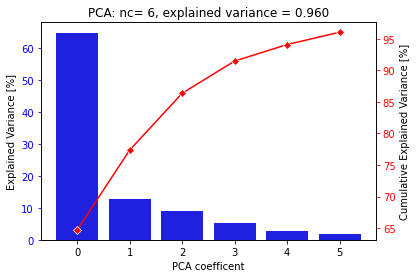

In [9]:
nComponents = 0.95  # variance ratio to be explained or number of components if integer

pca = PCA(n_components=nComponents).fit(X1)
pcaVariances = pca.explained_variance_ratio_
pcaComponents = [i for i in range(len(pcaVariances))]

ax = sns.barplot(pcaComponents, pcaVariances*100, color='b');
ax2 = ax.twinx()
ax2 = sns.lineplot(pcaComponents, np.cumsum(pcaVariances)*100, color='r', marker='D');
ax.tick_params(axis='y', colors='b')
ax2.tick_params(axis='y', colors='r')

ax.set_title('PCA: nc= ' + str(pcaVariances.shape[0]) + ', explained variance = ' + str(sum(pcaVariances))[:5])
ax.set_xlabel('PCA coefficent')
ax.set_ylabel('Explained Variance [%]')
ax2.set_ylabel('Cumulative Explained Variance [%]')
pass;

### Building x2 by transforming the x1 data with the previous PCA model and scaling X2

In [10]:
X2 = pca.fit_transform(X1)
X1_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X1)
X2_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X2)

### Creating pandas dataframe versions of the scaled x and x2, adding their labels

In [15]:
dfx2 = pd.DataFrame(X2_scaled)
dfx2 = dfx2.copy()
dfx2['y'] = y
dfx2['y2'] = y2

dfx2.sample(3)

,0,1,2,3,4,5,y,y2
191,0.340074,0.092909,0.288456,-0.332108,0.516566,-0.166527,4,0
725,-0.504170,-0.391499,-0.689593,-0.537331,0.267094,-0.155607,15,1
378,-0.137138,0.395154,-0.444405,-0.461570,-0.009059,-0.160839,8,0


### Apply the k-means algorithm with the reduced dimensions;
- Check the results visually by plotting side by side your clustering results and the correct labels in 3D (using only 3 dimensions of the PCA in the input space)

In [65]:
model_17 = KMeans(n_clusters=17)
model_17.fit(X2_scaled)

model_2 = KMeans(n_clusters=2, n_init=20)
model_2.fit(X2_scaled)

yPred = model_17.predict(X2_scaled)
yPred2 = model_2.predict(X2_scaled)

KMeans(n_clusters=17)

KMeans(n_clusters=2, n_init=20)

Adding Predicted Labels

In [66]:
dfx2 = dfx2.copy()
dfx2['cluster'] = yPred+1
dfx2['cluster2'] = yPred2

dfx2.sample(10)

,0,1,2,3,4,5,y,y2,cluster,cluster2
495,-0.462870,-0.352393,-0.425286,-0.469183,0.129473,-0.470650,10,1,9,1
501,-0.865644,-0.264923,0.622846,0.050078,0.124310,-0.367800,11,1,17,1
250,0.411312,-0.592082,-0.233990,0.179903,-0.432611,0.315632,6,0,2,0
585,-0.848460,-0.407245,0.335253,-0.425115,-0.103467,-0.309448,12,1,17,1
529,-0.824304,-0.624004,0.054792,-0.330138,0.174438,-0.018445,11,1,5,1
814,-0.932926,-0.453308,0.534591,-0.099146,0.217222,0.233427,17,1,16,1
486,-0.625286,-0.265182,-0.344421,-0.487872,0.089432,-0.450650,10,1,9,1
244,-0.152488,0.883117,0.028461,-0.592955,-0.155394,0.891013,5,0,7,1
140,0.886286,-0.751312,0.191736,-0.603850,0.418471,0.289608,3,0,12,0
99,0.479860,-0.557799,0.116804,-0.531540,0.294097,-0.391267,2,0,3,0


Comparison between the original 17 classes and the k-means 17 clusters

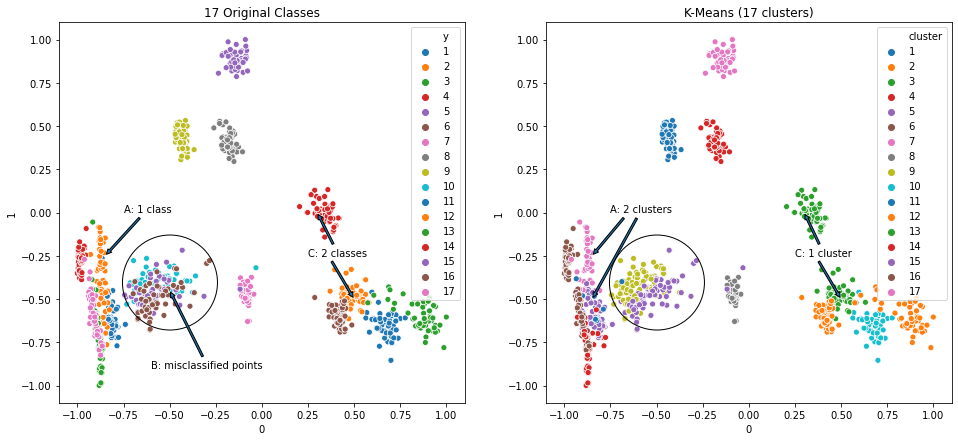

In [80]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 7))

ax1 = sns.scatterplot(data=dfx2, x=0, y=1, hue='y', palette='tab10',  ax=ax1)
ax1.set_title('17 Original Classes')
# __annotations__
ax1.text(-.55,-.5," ", bbox=dict(boxstyle='circle',facecolor='none', edgecolor='black'), size=60)
ax1.annotate("A: 1 class", xy=(-.85,-.25), xytext=(-.75,0), arrowprops=dict(arrowstyle='simple'))
ax1.annotate("B: misclassified points", xy=(-.5,-.45), xytext=(-.6,-.9), arrowprops=dict(arrowstyle='simple'))
ax1.annotate("C: 2 classes", xy=(.30,0), xytext=(.25,-.25), arrowprops=dict(arrowstyle='simple'))
ax1.annotate("            ", xy=(.50,-.5), xytext=(.25,-.25), arrowprops=dict(arrowstyle='simple'))

# __________

ax2 = sns.scatterplot(data=dfx2, x=0, y=1, hue='cluster', palette='tab10',  ax=ax2)
ax2.set_title('K-Means (17 clusters)')
# __annotations__
ax2.text(-.55,-.5," ", bbox=dict(boxstyle='circle',facecolor='none', edgecolor='black'), size=60)
ax2.annotate("A: 2 clusters", xy=(-.85,-.50), xytext=(-.75,0), arrowprops=dict(arrowstyle='simple'))
ax2.annotate("             ", xy=(-.85,-.25), xytext=(-.75,0), arrowprops=dict(arrowstyle='simple'))
ax2.annotate("C: 1 cluster", xy=(.30,0), xytext=(.25,-.25), arrowprops=dict(arrowstyle='simple'))
ax2.annotate("            ", xy=(.50,-.5), xytext=(.25,-.25), arrowprops=dict(arrowstyle='simple'))

pass;


Note: 
1. Trying to make a relationship between classes and clusters works fine for some isolated clusters in the above space of features 0 and 1.
2. But for some points marked by "A", "B" and "C" in the above graphs we see some problems if we used the clusters to make a classification
3. Results change a lot with each time it is executed, showing that the problem of clustering is very sensitive to the initialization of the centers of the clusters, as explained in the lessons.

Comparison between the 17 original classes grouped in two states: [damaged, undamaged] and the k-means clusters with only two clusters

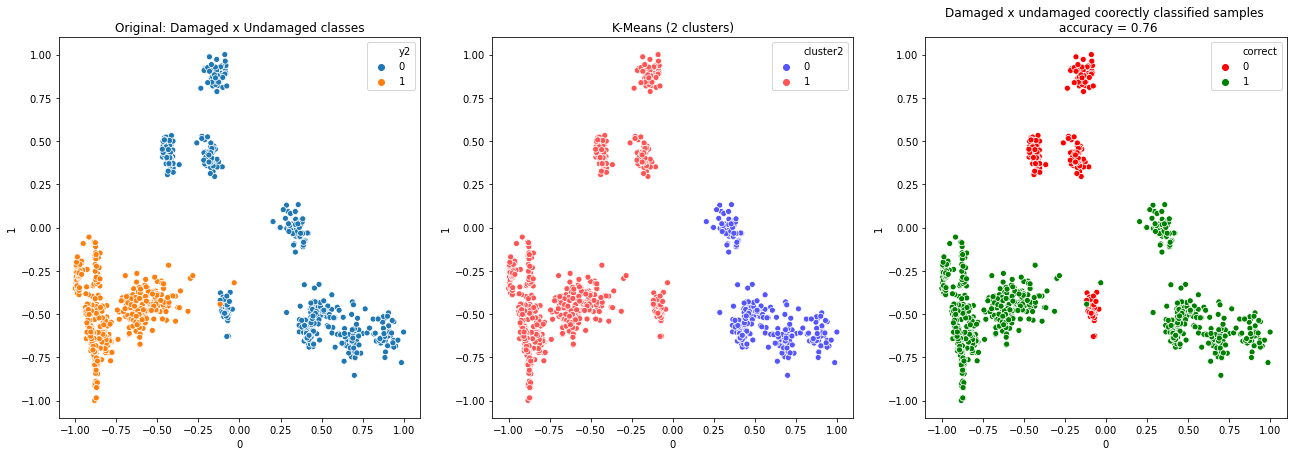

In [68]:
dfx2 = dfx2.copy()
dfx2['correct'] = 1* (dfx2['y2'] == dfx2['cluster2'])

# % of well classified samples
acc = dfx2['correct'].value_counts(normalize=True)[1]

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(22, 7))

ax1 = sns.scatterplot(data=dfx2, x=0, y=1, hue='y2', palette='tab10',  ax=ax1)
ax1.set_title('Original: Damaged x Undamaged classes')

ax2 = sns.scatterplot(data=dfx2, x=0, y=1, hue='cluster2', palette='seismic',  ax=ax2)
ax2.set_title('K-Means (2 clusters)')

ax3 = sns.scatterplot(data=dfx2, x=0, y=1, hue='correct', palette=['r', 'g'], ax=ax3)
ax3.set_title(f'Damaged x undamaged coorectly classified samples \n accuracy = {acc:.2f}')
pass;


Note: 
1. Trying to predict the accuracy in classifying an observation as correct consudering only damaged vs undamaged failure status lead to a result of about 76% correct predictions

### Optional: try to assign to clusters the label which contain most instances of a class, and build the confusion matrices based on this information (this will require some coding).

In [69]:
# for each cluster, count possible labels
counts = dfx2.groupby(['cluster', 'y'])['y'].count()

# for each cluster, take the most frequent label
counts = counts.sort_values(ascending=False).groupby(level=0).head(1)
counts

cluster  y 
7        5     50
13       4     50
8        7     50
2        6     50
3        2     50
11       9     50
4        8     50
6        14    50
12       3     50
10       1     49
16       17    39
14       13    35
15       16    34
5        11    33
9        10    32
17       12    30
1        11     8
Name: y, dtype: int64

In [70]:
cluster=[]
label=[]

for c in counts.index:
    cluster.append(c[0])
    label.append(c[1])

dfCounts = pd.DataFrame({'cluster': cluster, 'label': label})
dfCounts

,cluster,label
0,7,5
1,13,4
2,8,7
3,2,6
4,3,2
5,11,9
6,4,8
7,6,14
8,12,3
9,10,1


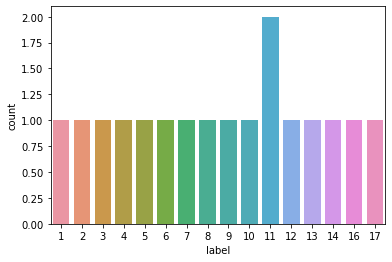

In [71]:
sns.countplot(data=dfCounts, x='label')

Note:

Label 11 used in 2 clusters, 15 not used

Now lets join the labels to our previous dataframe

In [81]:
# cluster is the key to join bothn tables
dfx3 = dfx2.join(dfCounts.set_index('cluster'), on='cluster')

# rename label to 'yPred'
dfx3.rename(columns = {'label':'y_pred'}, inplace = True)
dfx3.sample(10)

,0,1,2,3,4,5,y,y2,cluster,cluster2,correct,y_pred
440,-0.367366,0.363634,-0.490607,-0.311062,-0.319808,-0.909246,9,0,11,1,0,9
265,0.407639,-0.599299,-0.309187,-0.294365,-0.609311,0.328537,6,0,2,0,1,6
483,-0.644942,-0.353681,-0.348428,-0.493033,0.196431,-0.579978,10,1,9,1,1,10
107,0.921270,-0.624876,0.380974,-0.423083,0.604298,0.062994,3,0,12,0,1,3
322,-0.110273,-0.482990,-0.774134,0.058535,-0.008196,0.074297,7,0,8,1,0,7
268,0.445698,-0.595080,-0.334331,-0.011187,-0.769521,0.442106,6,0,2,0,1,6
126,0.606921,-0.478093,0.362641,-0.184550,0.691186,-0.260722,3,0,12,0,1,3
454,-0.510981,-0.366988,-0.504108,-0.629171,0.198500,-0.273727,10,1,9,1,1,10
464,-0.562188,-0.384662,-0.539250,-0.695820,0.095461,-0.303766,10,1,15,1,1,16
172,0.364322,0.027331,0.344071,-0.511485,0.434889,-0.188197,4,0,13,0,1,4


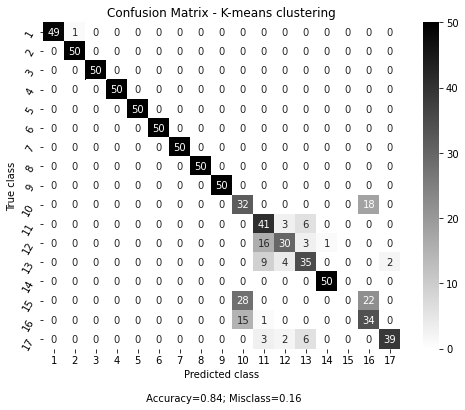

In [82]:
cm = confusion_matrix(dfx3['y'], dfx3['y_pred'])

accuracy = np.trace(cm) / np.sum(cm).astype('float')
misclass = 1 - accuracy

plt.figure(figsize=(8, 6))
sns.heatmap(data=cm, cmap='binary', annot=True)

plt.title('Confusion Matrix - K-means clustering')
plt.ylabel('True class')
plt.xlabel(f'Predicted class\n\n Accuracy={accuracy:0.2f}; Misclass={misclass:0.2f}')

target_names = [i+1 for i in range(17)]
plt.xticks(np.arange(17)+0.5, target_names)
plt.yticks(np.arange(17)+0.5, target_names, rotation=60)
pass;

Note: 
1. We have reached a good accuracy comparable to the supervised methods

### Visualize your dataset with t-SNE;

In [83]:
X2_reduced = TSNE().fit_transform(X2_scaled)

In [84]:
X2_scaled.shape
X2_reduced.shape

(850, 6)

(850, 2)

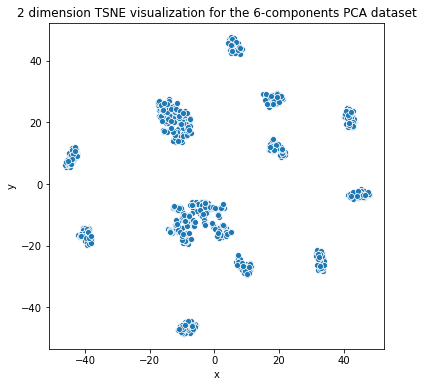

In [85]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=X2_reduced[:,0], y=X2_reduced[:,1])
plt.title('2 dimension TSNE visualization for the 6-components PCA dataset')
plt.xlabel('x')
plt.ylabel('y')
pass;

Note: 
1. We can see that the samples are well separated in 2D, although we don't see only 12 'clusters', if we would use that approach to try to classify the dataset


### Build a one-class classification SVM for nominal and failure modes

In [44]:
dfx2.shape

(850, 8)

In [89]:
print ('All X2: ', dfx2.shape)

# nominal, y2 = 0, sem falha
dfx_nominal = dfx2[dfx2['y2'] == 0]
dfx_failure = dfx2[dfx2['y2'] == 1]

X2_nominal = dfx_nominal.iloc[:,:6]
X2_nominal = np.asarray(X2_nominal)
print ('Only Nominal X2 (undamaged, or y2=0) shape: ', X2_nominal.shape)

X2_failure = dfx_failure.iloc[:,:6]
X2_failure = np.asarray(X2_failure)
print ('Only Failure X2 (damaged, or y2=1) shape: ', X2_failure.shape)

# instantiating model
model_nominal = OneClassSVM()
model_failure = OneClassSVM()

# fitting only with nominal (y2=0): 450 exemples
model_nominal.fit(X2_nominal);
# fitting only with failure (y2=1): 400 exemples
model_failure.fit(X2_failure);

# predicting for all X2 (850 observations)
# Returns -1 for outliers and 1 for inliers.
y_pred_nom = model_nominal.predict(X2_scaled)
y_pred_fail = model_failure.predict(X2_scaled)

pass;

All X2:  (850, 8)
Only Nominal X2 (undamaged, or y2=0) shape:  (450, 6)
Only Failure X2 (damaged, or y2=1) shape:  (400, 6)


### Codifying <b>y_pred_nom</b> and <b>y_pred_fail</b> to compare with the true class y2 (0,1)

- <b>y_pred_nom</b> was trained with nominal, so it contains -1 for outliers (failure, must be 1) and 1 for inliers (nominal, must be 0)
- <b>y_pred_fail</b> was trained with fault, so it contains -1 for outliers (nominal, must be 0) and 1 for inliers (failure must be 1)

In [90]:
y_pred_nom = np.where(y_pred_nom == 1, 0, 1)
y_pred_fail = np.where(y_pred_fail == 1, 1, 0)

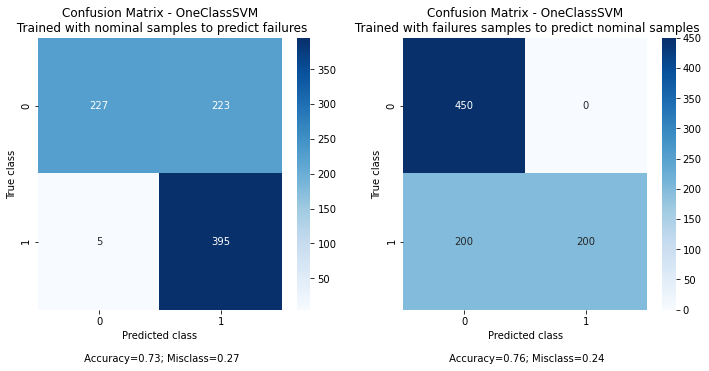

In [102]:
cm_n = confusion_matrix(dfx2['y2'], y_pred_nom)
cm_f = confusion_matrix(dfx2['y2'], y_pred_fail)

acc_n = np.trace(cm_n) / np.sum(cm_n).astype('float')
misclass_n = 1 - acc_n

acc_f = np.trace(cm_f) / np.sum(cm_f).astype('float')
misclass_f = 1 - acc_f

plt.subplots(1,2,figsize=(12, 5))

plt.subplot(121)
sns.heatmap(data=cm_n, cmap='Blues', annot=True, fmt='d')
plt.title('Confusion Matrix - OneClassSVM\n Trained with nominal samples to predict failures')
plt.ylabel('True class')
plt.xlabel(f'Predicted class\n\n Accuracy={acc_n:0.2f}; Misclass={misclass_n:0.2f}')

plt.subplot(122)
sns.heatmap(data=cm_f, cmap='Blues', annot=True, fmt='d')
plt.title('Confusion Matrix - OneClassSVM\n Trained with failures samples to predict nominal samples')
plt.ylabel('True class')
plt.xlabel(f'Predicted class\n\n Accuracy={acc_f:0.2f}; Misclass={misclass_f:0.2f}')

pass;

Note: 
1. Model trained only with the nominal samples was good in predicting the failure class (395/400)
2. Model trained only with the failure samples was good in predicting the nominal class (450/450)

### Comments:

1. In general we see some good results even when we don't have the output (y) used to train the model (unsupervised learning)